# 🧱 DCGAN - Bricks Data

In [1]:
import tensorflow as tf

print(tf.__version__)

2024-03-23 19:19:28.736815: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 19:19:29.170408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 19:19:30.995733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In this notebook, we'll walk through the steps required to train your own DCGAN on the bricks dataset

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

import sys

sys.path.append("/home/thomas/Generative_Deep_Learning_2nd_Edition/")

sys.path.append("/home/azureuser/Generative_Deep_Learning_2nd_Edition/")


from notebooks.utils import display, sample_batch

## 0. Parameters <a name="parameters"></a>

In [5]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

data_path = "/home/thomas/Generative_Deep_Learning_2nd_Edition/data"
# data_path = "/home/azureuser/cloudfiles/code/Data/data"

## 1. Prepare the data <a name="prepare"></a>

In [6]:
train_data = utils.image_dataset_from_directory(
    data_path + "/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files.


2024-03-23 19:19:53.675510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 19:19:53.863881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 19:19:53.863961: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 19:19:53.867554: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 19:19:53.867604: I external/local_xla/xla/stream_executor

In [7]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [8]:
train_sample = sample_batch(train)

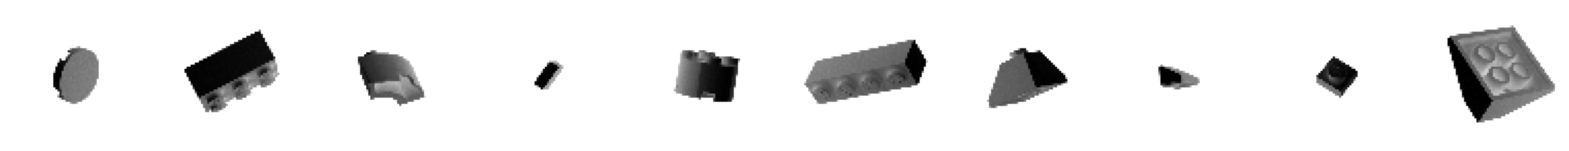

In [9]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [10]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 1)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,312 (10.55 MB)

 Trainable params: 2,763,520 (10.54 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [11]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 1)      │         1,024 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,576,576 (13.64 MB)

 Trainable params: 3,574,656 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [12]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(generated_images, training=True)

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [13]:
# Create a DCGAN
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

In [14]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [15]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [16]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

Epoch 1/300


I0000 00:00:1711196403.344899    6135 service.cc:145] XLA service 0x7fce6808cb00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711196403.345172    6135 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-03-23 19:20:03.675771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1711196403.921471    6135 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
2024-03-23 19:20:04.455121: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1711196426.635778    6135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetim

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - d_acc: 0.8469 - d_fake_acc: 0.8437 - d_loss: 0.2411 - d_real_acc: 0.8501 - g_acc: 0.1563 - g_loss: 4.5421
Saved to ./output/generated_img_000.png


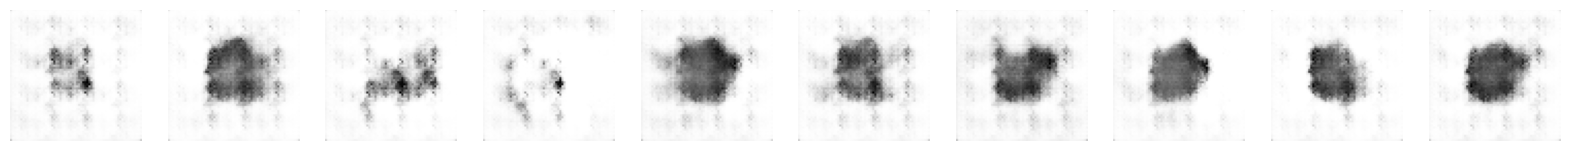

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 171ms/step - d_acc: 0.8469 - d_fake_acc: 0.8437 - d_loss: 0.2412 - d_real_acc: 0.8501 - g_acc: 0.1563 - g_loss: 4.5406
Epoch 2/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - d_acc: 0.9049 - d_fake_acc: 0.9084 - d_loss: 0.0649 - d_real_acc: 0.9014 - g_acc: 0.0916 - g_loss: 4.0863
Saved to ./output/generated_img_001.png


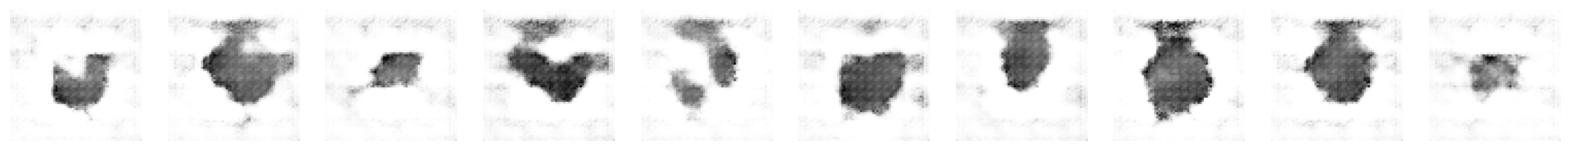

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - d_acc: 0.9048 - d_fake_acc: 0.9083 - d_loss: 0.0651 - d_real_acc: 0.9014 - g_acc: 0.0917 - g_loss: 4.0864
Epoch 3/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - d_acc: 0.8704 - d_fake_acc: 0.8735 - d_loss: 0.1429 - d_real_acc: 0.8674 - g_acc: 0.1265 - g_loss: 4.0485
Saved to ./output/generated_img_002.png


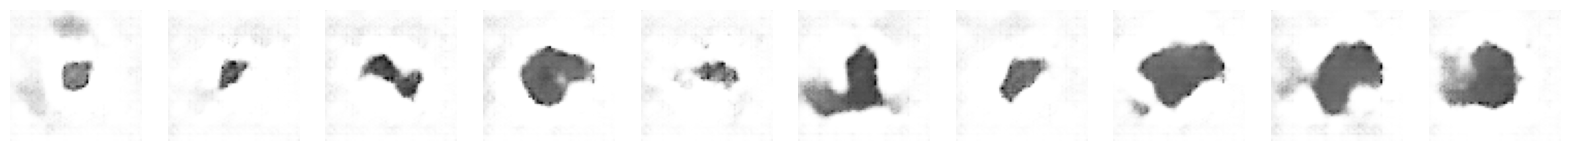

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - d_acc: 0.8704 - d_fake_acc: 0.8734 - d_loss: 0.1430 - d_real_acc: 0.8674 - g_acc: 0.1266 - g_loss: 4.0488
Epoch 4/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - d_acc: 0.8690 - d_fake_acc: 0.8712 - d_loss: 0.1741 - d_real_acc: 0.8668 - g_acc: 0.1288 - g_loss: 3.3458
Saved to ./output/generated_img_003.png


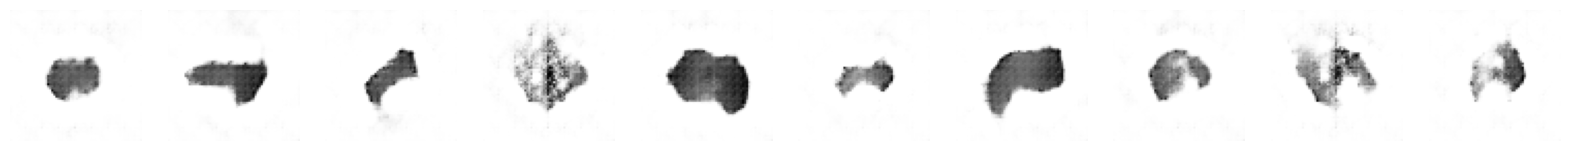

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 142ms/step - d_acc: 0.8690 - d_fake_acc: 0.8712 - d_loss: 0.1740 - d_real_acc: 0.8668 - g_acc: 0.1288 - g_loss: 3.3468
Epoch 5/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - d_acc: 0.8830 - d_fake_acc: 0.8840 - d_loss: 0.1208 - d_real_acc: 0.8820 - g_acc: 0.1160 - g_loss: 4.1188
Saved to ./output/generated_img_004.png


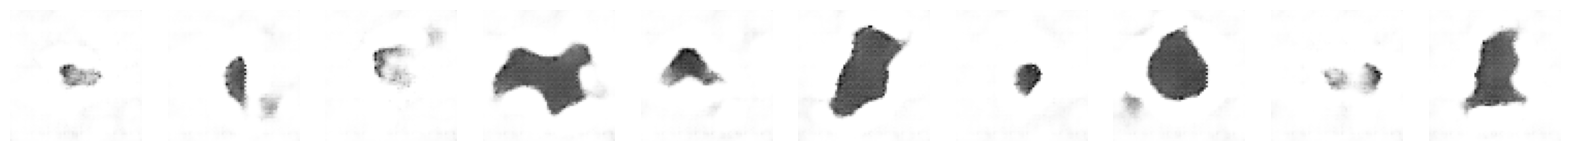

313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - d_acc: 0.8830 - d_fake_acc: 0.8840 - d_loss: 0.1208 - d_real_acc: 0.8820 - g_acc: 0.1160 - g_loss: 4.1186
Epoch 6/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - d_acc: 0.8746 - d_fake_acc: 0.8713 - d_loss: 0.1672 - d_real_acc: 0.8779 - g_acc: 0.1287 - g_loss: 3.7564
Saved to ./output/generated_img_005.png


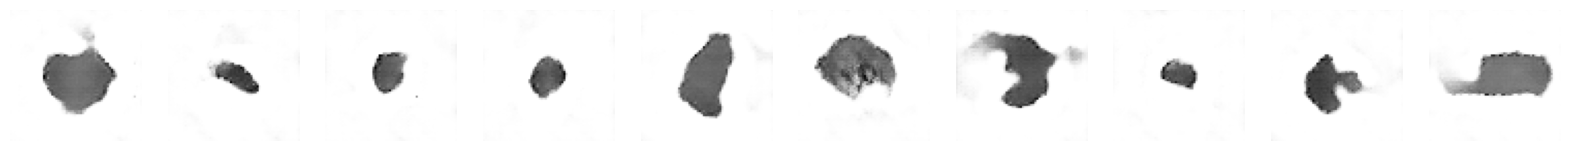

313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - d_acc: 0.8746 - d_fake_acc: 0.8713 - d_loss: 0.1671 - d_real_acc: 0.8779 - g_acc: 0.1287 - g_loss: 3.7566
Epoch 7/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - d_acc: 0.8834 - d_fake_acc: 0.8834 - d_loss: 0.1331 - d_real_acc: 0.8833 - g_acc: 0.1166 - g_loss: 3.9902
Saved to ./output/generated_img_006.png


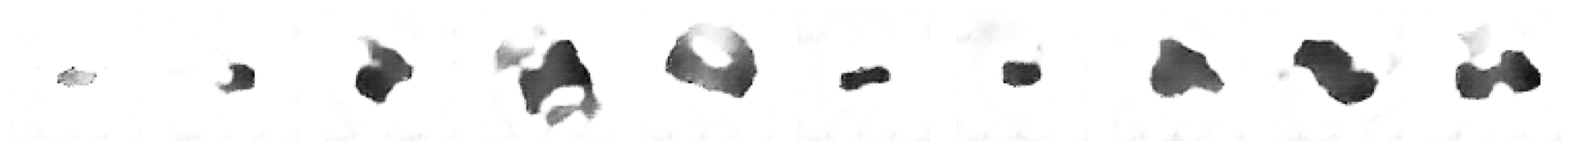

313/313 ━━━━━━━━━━━━━━━━━━━━ 64s 200ms/step - d_acc: 0.8834 - d_fake_acc: 0.8835 - d_loss: 0.1330 - d_real_acc: 0.8834 - g_acc: 0.1165 - g_loss: 3.9904
Epoch 8/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - d_acc: 0.8668 - d_fake_acc: 0.8642 - d_loss: 0.1627 - d_real_acc: 0.8695 - g_acc: 0.1358 - g_loss: 4.4362
Saved to ./output/generated_img_007.png


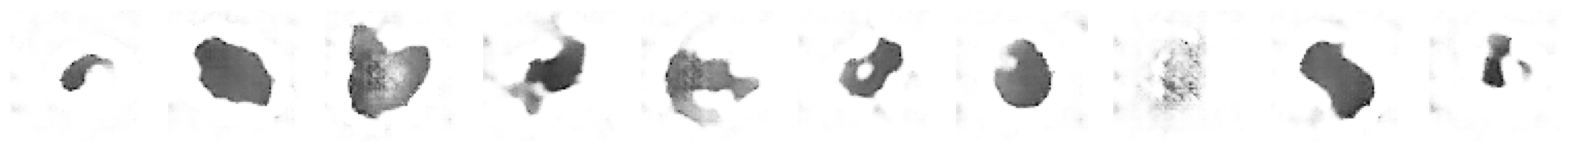

313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 464ms/step - d_acc: 0.8669 - d_fake_acc: 0.8642 - d_loss: 0.1626 - d_real_acc: 0.8695 - g_acc: 0.1358 - g_loss: 4.4354
Epoch 9/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - d_acc: 0.9028 - d_fake_acc: 0.9041 - d_loss: 0.0738 - d_real_acc: 0.9016 - g_acc: 0.0959 - g_loss: 4.1723
Saved to ./output/generated_img_008.png


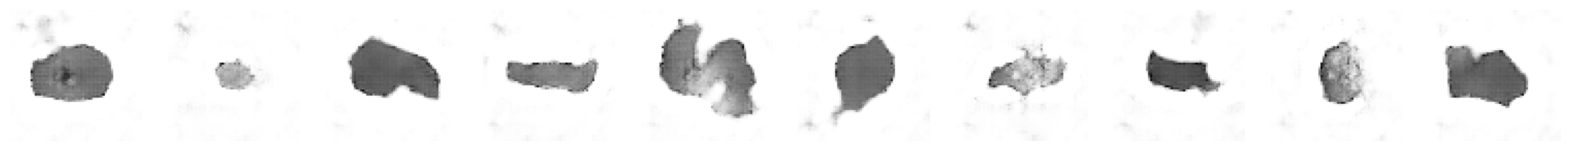

313/313 ━━━━━━━━━━━━━━━━━━━━ 260s 823ms/step - d_acc: 0.9028 - d_fake_acc: 0.9041 - d_loss: 0.0738 - d_real_acc: 0.9016 - g_acc: 0.0959 - g_loss: 4.1727
Epoch 10/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - d_acc: 0.8890 - d_fake_acc: 0.8883 - d_loss: 0.0986 - d_real_acc: 0.8896 - g_acc: 0.1117 - g_loss: 4.6220
Saved to ./output/generated_img_009.png


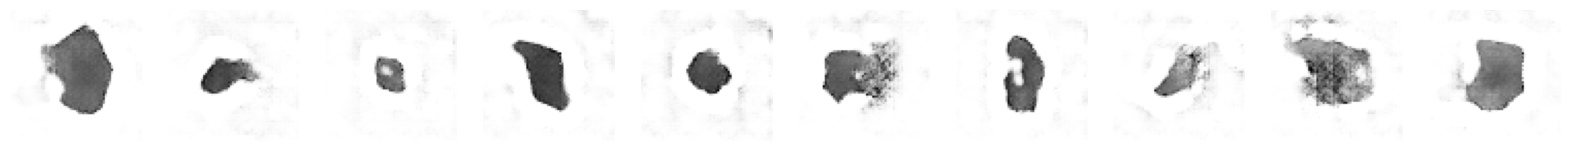

313/313 ━━━━━━━━━━━━━━━━━━━━ 231s 720ms/step - d_acc: 0.8890 - d_fake_acc: 0.8883 - d_loss: 0.0986 - d_real_acc: 0.8896 - g_acc: 0.1117 - g_loss: 4.6214
Epoch 11/300


2024-03-23 19:36:41.791308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 980 of 1024
2024-03-23 19:36:42.304945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - d_acc: 0.8900 - d_fake_acc: 0.8886 - d_loss: 0.0964 - d_real_acc: 0.8913 - g_acc: 0.1114 - g_loss: 4.4998
Saved to ./output/generated_img_010.png


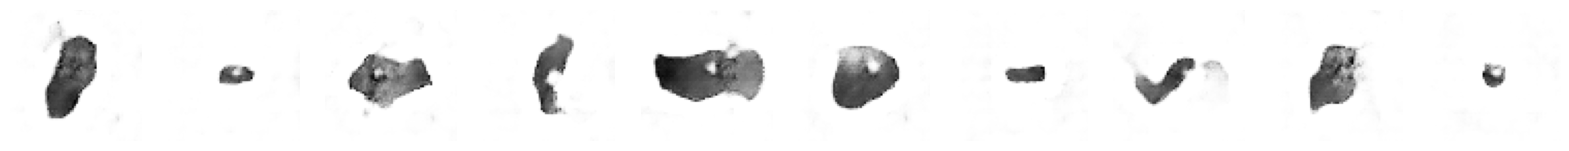

313/313 ━━━━━━━━━━━━━━━━━━━━ 307s 944ms/step - d_acc: 0.8900 - d_fake_acc: 0.8887 - d_loss: 0.0963 - d_real_acc: 0.8914 - g_acc: 0.1113 - g_loss: 4.5002
Epoch 12/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - d_acc: 0.9207 - d_fake_acc: 0.9212 - d_loss: -0.0269 - d_real_acc: 0.9202 - g_acc: 0.0788 - g_loss: 5.0741
Saved to ./output/generated_img_011.png


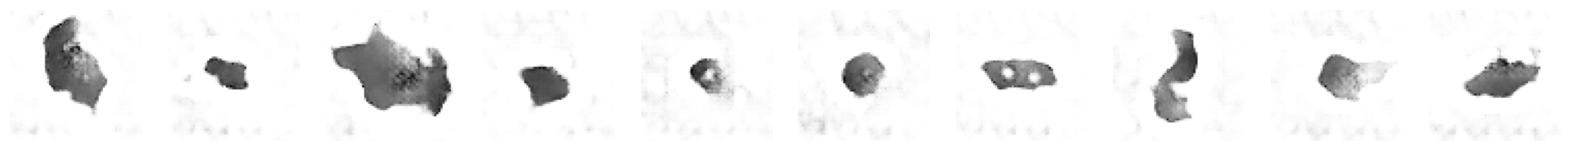

313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 274ms/step - d_acc: 0.9206 - d_fake_acc: 0.9211 - d_loss: -0.0267 - d_real_acc: 0.9202 - g_acc: 0.0789 - g_loss: 5.0736
Epoch 13/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - d_acc: 0.9202 - d_fake_acc: 0.9215 - d_loss: -0.0247 - d_real_acc: 0.9189 - g_acc: 0.0785 - g_loss: 4.9317
Saved to ./output/generated_img_012.png


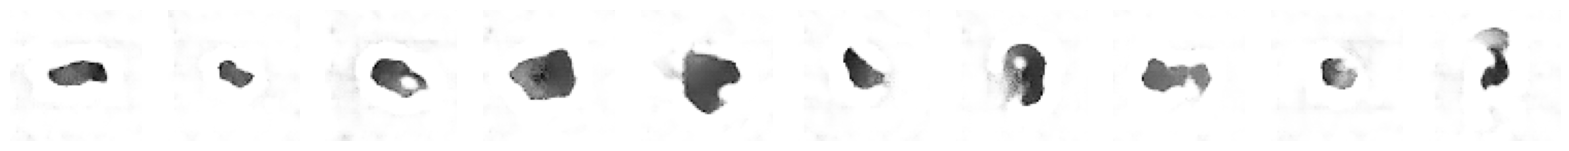

313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 219ms/step - d_acc: 0.9202 - d_fake_acc: 0.9215 - d_loss: -0.0248 - d_real_acc: 0.9190 - g_acc: 0.0785 - g_loss: 4.9324
Epoch 14/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - d_acc: 0.8863 - d_fake_acc: 0.8887 - d_loss: 0.1628 - d_real_acc: 0.8839 - g_acc: 0.1113 - g_loss: 5.1802
Saved to ./output/generated_img_013.png


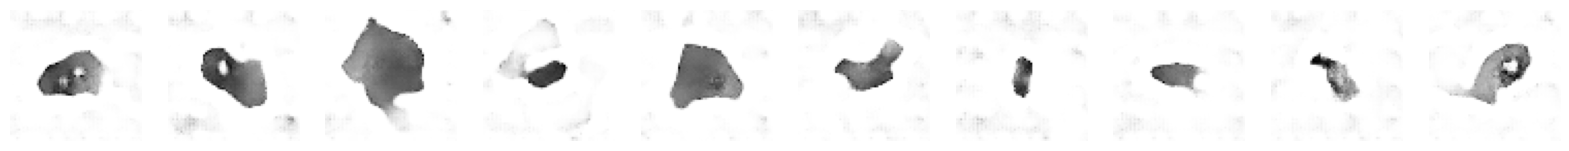

313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 193ms/step - d_acc: 0.8864 - d_fake_acc: 0.8887 - d_loss: 0.1625 - d_real_acc: 0.8840 - g_acc: 0.1113 - g_loss: 5.1797
Epoch 15/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - d_acc: 0.9298 - d_fake_acc: 0.9276 - d_loss: -0.0384 - d_real_acc: 0.9320 - g_acc: 0.0724 - g_loss: 5.2237
Saved to ./output/generated_img_014.png


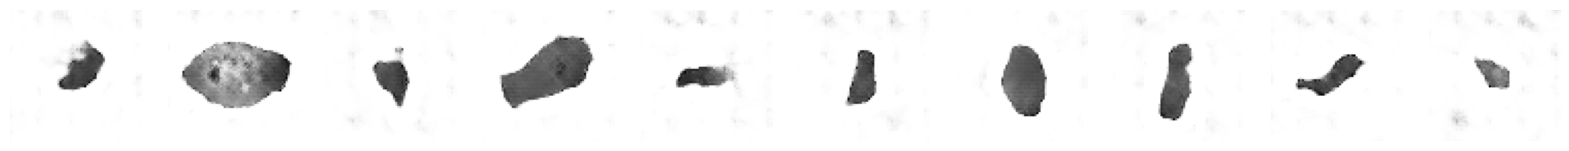

313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step - d_acc: 0.9298 - d_fake_acc: 0.9275 - d_loss: -0.0384 - d_real_acc: 0.9320 - g_acc: 0.0725 - g_loss: 5.2243
Epoch 16/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - d_acc: 0.9095 - d_fake_acc: 0.9095 - d_loss: 0.0377 - d_real_acc: 0.9094 - g_acc: 0.0905 - g_loss: 5.3671
Saved to ./output/generated_img_015.png


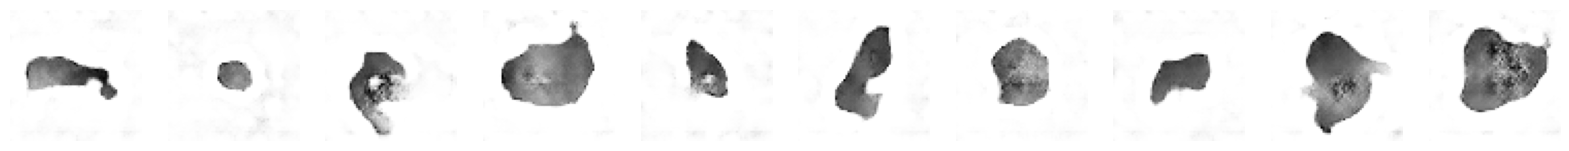

313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 173ms/step - d_acc: 0.9094 - d_fake_acc: 0.9095 - d_loss: 0.0377 - d_real_acc: 0.9094 - g_acc: 0.0905 - g_loss: 5.3669
Epoch 17/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - d_acc: 0.9242 - d_fake_acc: 0.9249 - d_loss: -0.0171 - d_real_acc: 0.9234 - g_acc: 0.0751 - g_loss: 5.4134
Saved to ./output/generated_img_016.png


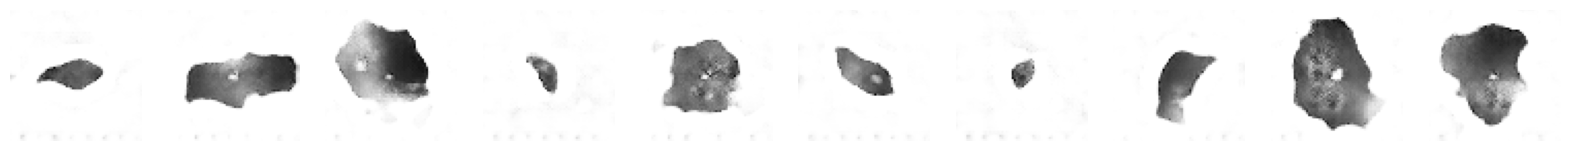

313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 185ms/step - d_acc: 0.9242 - d_fake_acc: 0.9249 - d_loss: -0.0173 - d_real_acc: 0.9235 - g_acc: 0.0751 - g_loss: 5.4143
Epoch 18/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - d_acc: 0.9077 - d_fake_acc: 0.9104 - d_loss: 0.0505 - d_real_acc: 0.9050 - g_acc: 0.0896 - g_loss: 5.5255
Saved to ./output/generated_img_017.png


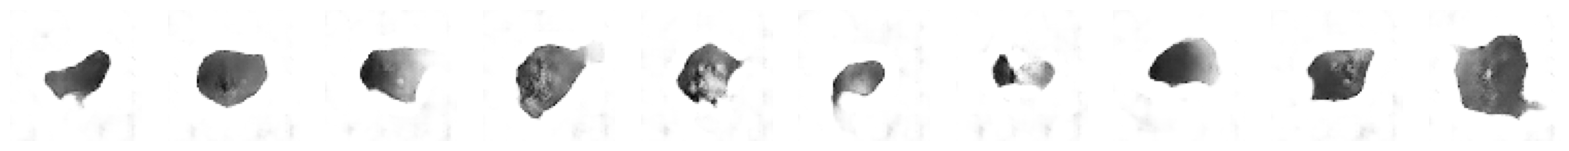

313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 177ms/step - d_acc: 0.9077 - d_fake_acc: 0.9104 - d_loss: 0.0502 - d_real_acc: 0.9051 - g_acc: 0.0896 - g_loss: 5.5263
Epoch 19/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - d_acc: 0.9189 - d_fake_acc: 0.9172 - d_loss: 0.0643 - d_real_acc: 0.9206 - g_acc: 0.0828 - g_loss: 5.9078
Saved to ./output/generated_img_018.png


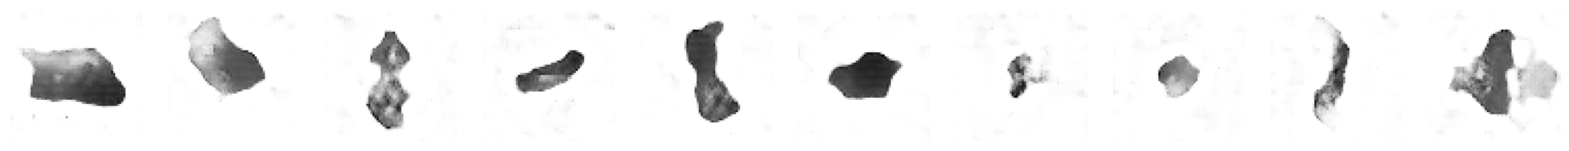

313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 189ms/step - d_acc: 0.9190 - d_fake_acc: 0.9172 - d_loss: 0.0640 - d_real_acc: 0.9207 - g_acc: 0.0828 - g_loss: 5.9081
Epoch 20/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - d_acc: 0.9091 - d_fake_acc: 0.9068 - d_loss: 0.0048 - d_real_acc: 0.9114 - g_acc: 0.0932 - g_loss: 5.6208
Saved to ./output/generated_img_019.png


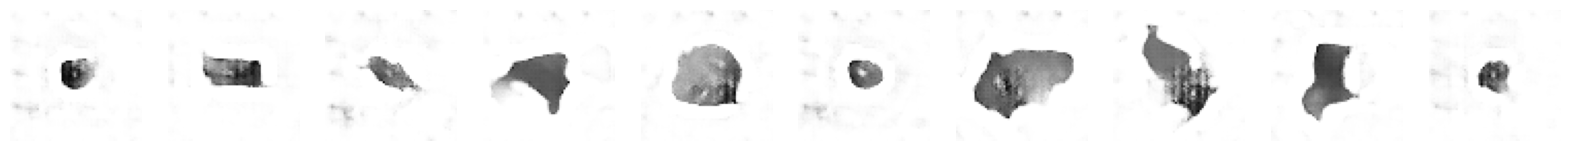

313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - d_acc: 0.9092 - d_fake_acc: 0.9069 - d_loss: 0.0044 - d_real_acc: 0.9115 - g_acc: 0.0931 - g_loss: 5.6226
Epoch 21/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - d_acc: 0.9181 - d_fake_acc: 0.9168 - d_loss: -0.0250 - d_real_acc: 0.9194 - g_acc: 0.0832 - g_loss: 6.6622
Saved to ./output/generated_img_020.png


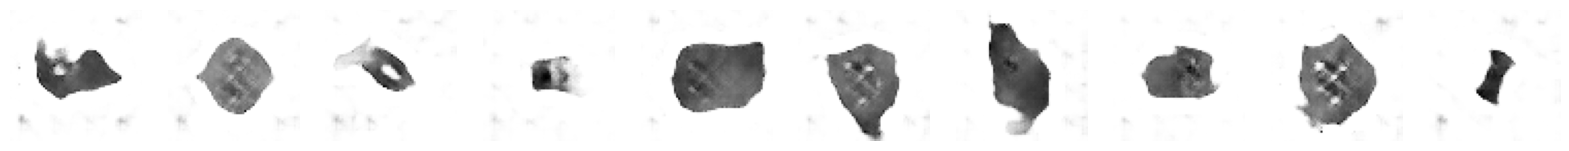

313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 156ms/step - d_acc: 0.9181 - d_fake_acc: 0.9169 - d_loss: -0.0251 - d_real_acc: 0.9194 - g_acc: 0.0831 - g_loss: 6.6609
Epoch 22/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - d_acc: 0.9478 - d_fake_acc: 0.9487 - d_loss: -0.1749 - d_real_acc: 0.9469 - g_acc: 0.0513 - g_loss: 7.0239
Saved to ./output/generated_img_021.png


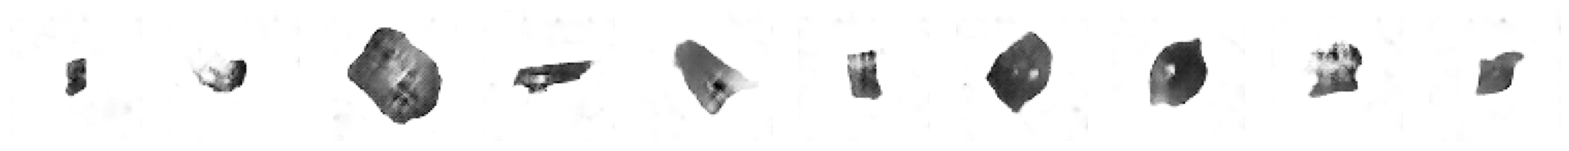

313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 158ms/step - d_acc: 0.9478 - d_fake_acc: 0.9486 - d_loss: -0.1748 - d_real_acc: 0.9469 - g_acc: 0.0514 - g_loss: 7.0238
Epoch 23/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - d_acc: 0.9206 - d_fake_acc: 0.9195 - d_loss: -0.0310 - d_real_acc: 0.9217 - g_acc: 0.0805 - g_loss: 6.5208
Saved to ./output/generated_img_022.png


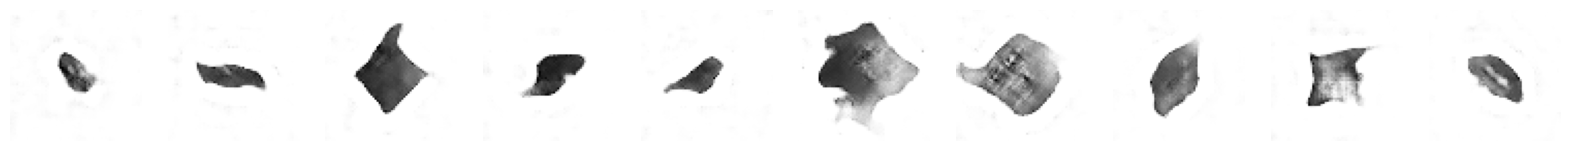

313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - d_acc: 0.9207 - d_fake_acc: 0.9195 - d_loss: -0.0312 - d_real_acc: 0.9218 - g_acc: 0.0805 - g_loss: 6.5218
Epoch 24/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - d_acc: 0.9293 - d_fake_acc: 0.9308 - d_loss: -0.0603 - d_real_acc: 0.9278 - g_acc: 0.0692 - g_loss: 7.0883
Saved to ./output/generated_img_023.png


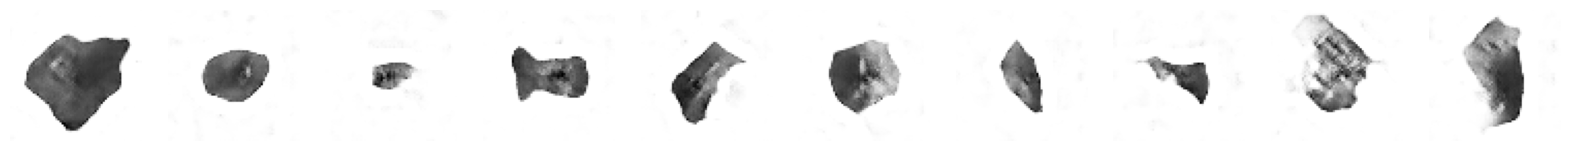

313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 220ms/step - d_acc: 0.9293 - d_fake_acc: 0.9308 - d_loss: -0.0600 - d_real_acc: 0.9277 - g_acc: 0.0692 - g_loss: 7.0876
Epoch 25/300
167/313 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - d_acc: 0.9703 - d_fake_acc: 0.9716 - d_loss: -0.2696 - d_real_acc: 0.9691 - g_acc: 0.0284 - g_loss: 7.6277

KeyboardInterrupt: 

In [17]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [ ]:
# Save the final models
generator.save("./models/generator.keras")
discriminator.save("./models/discriminator.keras")

## 3. Generate new images <a name="decode"></a>

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

In [ ]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()